In [3]:
import numpy as np
import pandas as pd
from fastai.text import *
from pathlib import Path

In [4]:
if not os.path.isdir('../nlp-model'):
    os.makedirs('../nlp-model')
    
path_model = Path("../nlp-model")

In [5]:
train = pd.read_csv('../Desktop/train.csv')
test = pd.read_csv('../Desktop/test.csv')
sub = pd.read_csv('../Desktop/sample_submission.csv')

In [6]:
bs = 48
data_lm = (TextList.from_df(pd.concat([train[['text']], test[['text']]], ignore_index=True, axis=0), path_model)
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs=bs))

In [7]:
data_lm.show_batch()

idx,text
0,"# xxmaj alaska as smoke from # wildfires xxunk into a school xxbos # rockyfire xxmaj update = > xxmaj california xxmaj hwy . 20 closed in both xxunk due to xxmaj lake xxmaj county fire - # xxunk # wildfires xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk , xxmaj colorado xxmaj springs areas xxbos i 'm on top of the"
1,xxunk xxbos : xxunk : : xxmaj xxunk 3 : : xxmaj xxunk xxmaj annihilation : : http : / / t.co / xxunk via @youtube xxbos xxup u.s xxmaj national xxmaj park xxmaj services xxmaj tonto xxmaj national xxmaj forest : xxmaj stop the xxmaj annihilation of the xxmaj salt xxmaj river xxmaj wild xxmaj horse ... https : / / t.co / xxunk via @change xxbos xxunk can
2,xxmaj victims in xxmaj private xxmaj xxunk http : / / t.co / xxunk xxbos xxmaj new post from xxunk http : / / t.co / xxunk xxmaj new xxup xxunk xxmaj xxunk xxmaj attack xxmaj xxunk xxmaj user xxmaj xxunk xxmaj over xxmaj internet xxbos xxmaj israeli forces raid home of alleged car attack suspect http : / / t.co / xxunk # palestine xxbos xxmaj just had a
3,with the best xxunk skills yet . xxmaj nothing beats the xxunk xxup xxunk . xxbos xxmaj bit xxunk vs xxunk 3 xxunk blazing xxunk online : xxunk http : / / t.co / xxup xxunk xxbos xxmaj turn on your xxunk # xxunk is live on your # xxunk http : / / t.co / xxunk & & xxunk fm xxunk xxunk blazing all your hits xxbos xxunk i
4,xxmaj full reû _ http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj new xxmaj ladies xxmaj shoulder xxmaj tote xxmaj handbag xxmaj women xxmaj cross xxmaj body xxmaj bag xxmaj faux xxmaj leather xxmaj fashion xxmaj purse - xxmaj full reû _ http : / / t.co / xxunk http : / / t.co / xxunk xxbos xxmaj if you have a


In [8]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


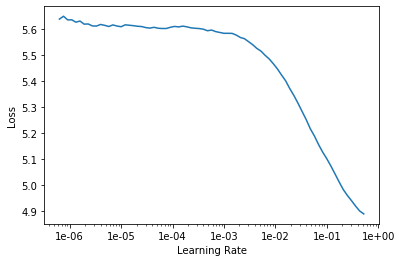

In [10]:
learn.recorder.plot(skip_end=15)

In [11]:
learn.fit_one_cycle(1, 1.3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.784640,3.266132,0.434392,00:09


In [13]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.268758,2.854872,0.498710,00:11
1,2.143828,2.851380,0.505324,00:11
2,1.884910,2.895251,0.504894,00:11


In [14]:
learn.save('fit-1')
learn.save_encoder('fine_tuned_enc')

In [16]:
df = train[['text', 'target']]

In [17]:
df_test = test[['text']]

In [18]:
bs = 16
data_clas = (TextList.from_df(df, path_model, vocab=data_lm.vocab)
             #.split_none()
             .split_by_rand_pct(0.1)
             .label_from_df('target')
             .add_test(TextList.from_df(df_test, path_model, vocab=data_lm.vocab))
             .databunch(bs=bs))

In [19]:
data_clas.show_batch(ds_type=DatasetType.Test)

text,target
xxbos xxup oh xxup my xxup xxunk xxup im xxup at xxup my xxup xxunk xxup house xxup and xxup this xxup post xxup it xxup was xxup on xxup her xxup counter xxup and i xxup screamed xxup bc i xxup thought xxup it xxup said xxup chris xxup xxunk http : / / t.co / xxunk,0
xxbos xxmaj we d xxmaj aug 8 ! # xxmaj mayhem @ xxmaj xxunk ! 19 + xxmaj event ! xxmaj july & & xxmaj aug xxmaj xxunk xxmaj free ! xxmaj tix - > http : / / t.co / xxunk xxmaj xxunk ( xxunk ) xxunk - xxunk http : / / t.co / xxunk,0
xxbos ' # xxup otrametlife ' i xxup swear xxup to xxup god i xxup didnt xxup even xxup read xxup it xxup properly xxup and i xxup though xxup it xxup said ' xxup xxunk xxup life ' xxup and xxup screamed . i xxup need xxup to xxup sleep xxup omfg . xxup xxunk .,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,0
xxbos xxmaj truth ... \n https : / / t.co / xxunk \n # xxmaj news \n # xxup bbc \n # xxup cnn \n # xxmaj islam \n # xxmaj truth \n # god \n # xxup isis \n # terrorism \n # xxmaj quran \n # xxmaj lies http : / / t.co / xxunk,0


In [20]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, FBeta(beta=1)])
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6852 items)
x: TextList
xxbos xxmaj our xxmaj xxunk are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj forgive us all,xxbos xxmaj all residents asked to ' shelter in place ' are being xxunk by officers . xxmaj no other evacuation or shelter in place orders are expected,xxbos xxunk people receive # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school,xxbos # flood # disaster xxmaj heavy rain causes flash flooding of streets in xxmaj xxunk , xxmaj colorado xxmaj springs areas
y: CategoryList
1,1,1,1,1
Path: ../nlp-model;

Valid: LabelList (761 items)
x: TextList
xxbos xxmaj oh shit its rly xxunk 
  a xxrep 5 a nd there 's the thunder and lightning 
  i missed summer storms,xxbos xxunk the bomb impact xxunk hit beyond kyle xxunk,xxbos xxmaj photo : weallheartonedirection : i wouldnûªt let xxmaj david electroc

In [21]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


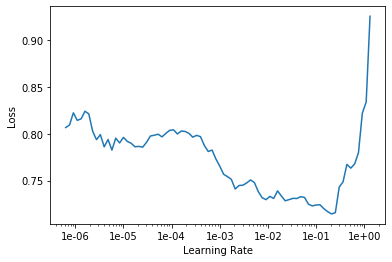

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.531279,0.465029,0.780552,0.726678,00:14


In [28]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.386360,0.399994,0.831800,0.791531,00:15


In [27]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.431761,0.421429,0.822602,0.777595,00:24


In [29]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.321260,0.413392,0.829172,0.792332,00:28
1,0.280410,0.418123,0.823916,0.789308,00:29


In [30]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test,  ordered=True)
preds = preds.argmax(dim=-1)

id = test['id']

In [31]:
my_submission = pd.DataFrame({'id': id, 'target': preds})
my_submission.to_csv('submission1.csv', index=False)